In [ ]:
# file management
import sys
import shutil
import urllib
import tarfile
import zipfile
from pathlib import Path
from copy import deepcopy
import pickle

import os

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable
from tqdm.notebook import tqdm, tnrange


import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path, mode="tar"):
    print("Extracting dataset... (it may take a while...)")
    if mode == "tar":
      with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    elif mode == "zip":
      with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Extraction completed!")

In [ ]:
train_url = "https://drive.usercontent.google.com/download?id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2&export=download&authuser=0&confirm=t&uuid=9004532d-1162-47b2-985c-492039597222&at=APZUnTWm8D1ZM5_aa68vV6nRf9FA:1705400593770"
train_dataset_name = "EFR_train_dataset.json"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

train_dataset_json_path = dataset_folder.joinpath(train_dataset_name)

if not train_dataset_json_path.exists():
    download_dataset(train_dataset_json_path, train_url)

Current work directory: /content


download?id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2&export=download&authuser=0&confirm=t&uuid=9004532d-1162-47b2-985…

Download complete!


In [ ]:
global_df = pd.read_json(train_dataset_json_path)

In [ ]:
# Replaces NaN values by 0 in lists of given row
def remove_nan(row):
    return [0 if pd.isna(x) else x for x in row]

# Checks that there are no NaN values in lists of given row
def nan_free(column):
    return all(all(pd.notna(x) for x in row) for row in column)

global_df['triggers'] = global_df['triggers'].apply(remove_nan)
nan_free(global_df['triggers'])

True

In [ ]:
# Assigns 80% of data to training set, without shuffling
train_df, test_df = train_test_split(global_df, test_size=0.2, shuffle=False)

# Assigns remaining 20% of data to test and validation set, without shuffling
test_df, eval_df = train_test_split(test_df, test_size=0.5, shuffle=False)

In [ ]:
print(len(train_df))
print(len(test_df))
print(len(eval_df))

3200
400
400


In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

### Preparing Data to be use in the Model


In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

*   Dialogue flattening

In [ ]:
erc_train_utterances = [u for row in train_df.utterances for u in row]
erc_train_emotions = [e for row in train_df.emotions for e in row]

erc_eval_utterances = [u for row in eval_df.utterances for u in row]
erc_eval_emotions = [e for row in eval_df.emotions for e in row]

erc_test_utterances = [u for row in test_df.utterances for u in row]
erc_test_emotions = [e for row in test_df.emotions for e in row]

*   Emotion label encoding to numerical values

In [ ]:
labelencoder = LabelEncoder()

erc_train_encoded_emotions = labelencoder.fit_transform(erc_train_emotions)
print(labelencoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
erc_eval_encoded_emotions = labelencoder.fit_transform(erc_eval_emotions)
print(labelencoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
erc_test_encoded_emotions = labelencoder.fit_transform(erc_test_emotions)
print(labelencoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]))

np.unique(erc_train_encoded_emotions)

['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


array([0, 1, 2, 3, 4, 5, 6])

*   Utterance tokenization

In [ ]:
erc_max_len = 100

erc_train_input_ids = [tokenizer.encode(u, add_special_tokens=True, max_length=erc_max_len, padding='max_length') for u in erc_train_utterances]
erc_eval_input_ids = [tokenizer.encode(u, add_special_tokens=True, max_length=erc_max_len, padding='max_length') for u in erc_eval_utterances]
erc_test_input_ids = [tokenizer.encode(u, add_special_tokens=True, max_length=erc_max_len, padding='max_length') for u in erc_test_utterances]

## Create attention mask
erc_train_attention_masks = []
erc_eval_attention_masks = []
erc_test_attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
erc_train_attention_masks = [[float(i>0) for i in seq] for seq in erc_train_input_ids]
erc_eval_attention_masks = [[float(i>0) for i in seq] for seq in erc_eval_input_ids]
erc_test_attention_masks = [[float(i>0) for i in seq] for seq in erc_test_input_ids]

*   Creating DataLoaders

In [ ]:
batch_size = 32
erc_train_data = TensorDataset(torch.tensor(erc_train_input_ids), torch.tensor(erc_train_attention_masks), torch.tensor(erc_train_encoded_emotions))
erc_train_sampler = RandomSampler(erc_train_data)
erc_train_dataloader = DataLoader(erc_train_data,sampler=erc_train_sampler,batch_size=batch_size)

erc_eval_data = TensorDataset(torch.tensor(erc_eval_input_ids), torch.tensor(erc_eval_attention_masks), torch.tensor(erc_eval_encoded_emotions))
erc_eval_sampler = RandomSampler(erc_eval_data)
erc_eval_dataloader = DataLoader(erc_eval_data,sampler=erc_eval_sampler,batch_size=batch_size)

In [ ]:
erc_test_data = TensorDataset(torch.tensor(erc_test_input_ids), torch.tensor(erc_test_attention_masks), torch.tensor(erc_test_encoded_emotions))
erc_test_sampler = RandomSampler(erc_test_data)
erc_test_dataloader = DataLoader(erc_test_data,sampler=erc_test_sampler,batch_size=batch_size)

### Model definition

In [ ]:
import torch
from torch import nn
from transformers import BertModel

In [ ]:
# to save models
!mkdir Models

In [ ]:
class BertERCModel(nn.Module):
  def __init__(self, output_size):
    super(BertERCModel, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
    self.drop = nn.Dropout(0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, output_size)

  def forward(self, input_ids, attention_mask):
    out1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    out2 = self.drop(out1.pooler_output)
    output = self.linear(out2)

    return output, out1.pooler_output
erc_model = BertERCModel(7).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Metrics

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def compute_metrics(true_labels, preds):
  macro_f1 = f1_score(preds, true_labels, average='macro')

  return macro_f1

### Training

In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [ ]:
erc_lr = 2e-5
erc_adam_epsilon = 1e-8

best_erc_path = 'Models/erc_model.pt'

def erc_loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

erc_epochs = 3

In [ ]:
def train_erc(erc_model, erc_optimizer):

  min_val_loss = np.Inf
  train_loss_set = []
  learning_rate = []

  # Gradients gets accumulated by default
  erc_model.zero_grad()

  # tnrange is a tqdm wrapper around the normal python range
  for _ in tnrange(1,erc_epochs+1,desc='Epoch'):
    print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
    # Calculate total loss for this epoch
    batch_loss = 0

    for step, batch in enumerate(erc_train_dataloader):
      erc_model.train()

      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_input_mask, b_labels = batch

      outputs = erc_model(b_input_ids, attention_mask=b_input_mask)
      loss = erc_loss_fn(outputs[0], b_labels)

      loss.backward()

      # Clip the norm of the gradients to 1.0 bc gradient clipping is not in AdamW anymore
      torch.nn.utils.clip_grad_norm_(erc_model.parameters(), 1.0)

      erc_optimizer.step()
      erc_optimizer.zero_grad()

      batch_loss += loss.item()

    # Calculate the average loss over the training data.
    avg_train_loss = batch_loss / len(erc_train_dataloader)

    train_loss_set.append(avg_train_loss)
    print(F'\n\tAverage Training loss: {avg_train_loss}')

    # Validation
    erc_model.eval()

    # Tracking variables
    eval_accuracy, eval_mcc_accuracy, nb_eval_steps = 0, 0, 0

    for batch in erc_eval_dataloader:

      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
        outputs = erc_model(b_input_ids, attention_mask=b_input_mask)

      logits = outputs[0].to('cpu').numpy()
      label_ids = b_labels.to('cpu').numpy()
      loss = erc_loss_fn(outputs[0], b_labels)

      batch_loss += loss.item()

      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

      df_metrics = pd.DataFrame({'Epoch': erc_epochs,'Actual_class': labels_flat,'Predicted_class': pred_flat})

      tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
      tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)

      eval_accuracy += tmp_eval_accuracy
      eval_mcc_accuracy += tmp_eval_mcc_accuracy
      nb_eval_steps += 1

    avg_eval_loss = batch_loss / len(erc_eval_dataloader)

    print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
    print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

  return erc_model

### Pipeline

In [ ]:
def make_erc_preds(model, test_loader):
  output_preds = []
  true_labels = []
  model.eval()
  for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      logits = model(b_input_ids, attention_mask=b_input_mask)
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    output_preds.extend(logits)
    true_labels.extend(label_ids)

  erc_pred_outs = [np.argmax(row) for row in output_preds]
  return true_labels, output_preds, erc_pred_outs

In [ ]:
def erc_pipeline(seed, issaved):
  print(f'Pipeline on seed {seed}')
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  erc_model = BertERCModel(7).to(device)
  erc_optimizer = torch.optim.AdamW(erc_model.parameters(), lr=erc_lr, eps=erc_adam_epsilon)

  if issaved:
    erc_model = torch.load(f'drive/MyDrive/Models/ERC_{seed}.pt', map_location=device)
  else:
    erc_model = train_erc(erc_model, erc_optimizer)

  torch.save(erc_model, f'Models/ERC_{seed}.pt')
  y, y_pred_scores, y_preds = make_erc_preds(erc_model, erc_test_dataloader)
  erc_f1s.append(compute_metrics(y, y_preds))

In [ ]:
erc_f1s = []
seeds = [38921, 101, 27, 2839, 12]
for seed in seeds:
  erc_pipeline(seed, issaved=False)

Pipeline on seed 38921
Pipeline on seed 101
Pipeline on seed 27
Pipeline on seed 2839
Pipeline on seed 12


In [ ]:
print(f"best F1-score {max(erc_f1s)} on seed {seeds[np.argmax(erc_f1s)]}")

best F1-score 0.3939154216111674 on seed 27


### Error Analysis

We use model with the best F1-score to do our Error Analysis

In [ ]:
erc_model = torch.load('Models/ERC_27.pt')
y, y_scores, y_preds = make_erc_preds(erc_model, erc_test_dataloader)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, auc, roc_auc_score, average_precision_score

           0,       1,        2,     3,      4,        5,      6


array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype='<U8')

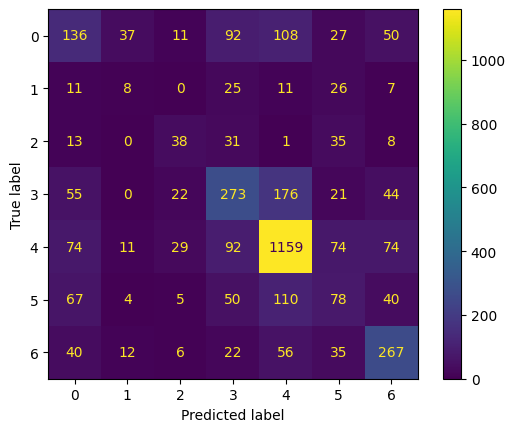

In [ ]:
cm = confusion_matrix(y, y_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()
# plt.savefig('drive/MyDrive/ERCConfusionMatrix.pdf')
print('           0,       1,        2,     3,      4,        5,      6')
labelencoder.inverse_transform([0, 1, 2, 3, 4, 5, 6])

We observe that the most misclassications are:


*   Joy misclassified as Neutral (176)
*   Sadness as Neutral (110)
*   Anger misclassified as Neutral (108)


#### ROC with macro-average

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit([0,1,2,3,4,5,6])

LabelBinarizer()

In [ ]:
# we convert to scores to pb distribution with softmax
y_tens = torch.tensor(y_scores)
y_softmax_score = torch.nn.functional.softmax(y_tens, 1).detach().numpy()

In [ ]:
y_ohe = lb.transform(y)

n_classes = len(labelencoder.classes_)
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_ohe[:, i], y_softmax_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

roc_auc

{0: 0.6985331761653333,
 1: 0.6856843630099444,
 2: 0.7904600640449697,
 3: 0.7595947035510282,
 4: 0.8173380106456707,
 5: 0.6378187735002433,
 6: 0.8544249096741565,
 'macro': 0.7491331648491626}

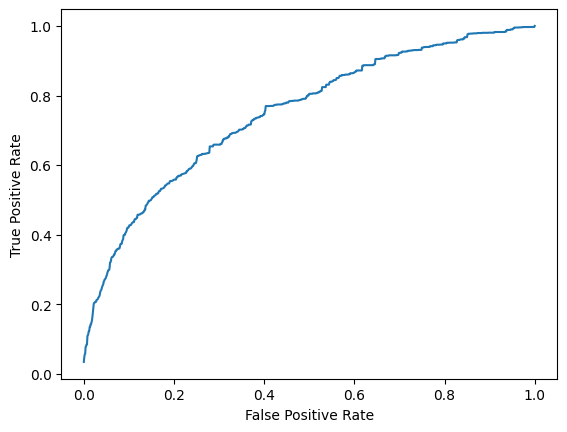

In [ ]:
RocCurveDisplay(fpr=fpr['macro'], tpr=tpr['macro']).plot()

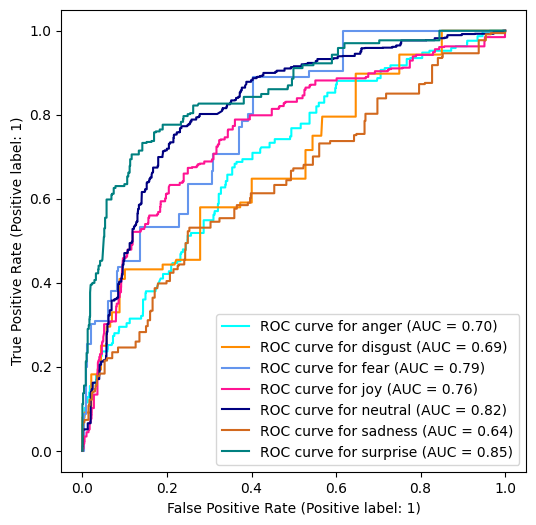

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

colors = ["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "chocolate", "teal"]
for class_id, color in zip(range(n_classes), colors):
  RocCurveDisplay.from_predictions(
        y_ohe[:, class_id],
        y_softmax_score[:, class_id],
        name=f"ROC curve for {labelencoder.classes_[class_id]}",
        color=color,
        ax=ax,
    )


#### Recall Precision

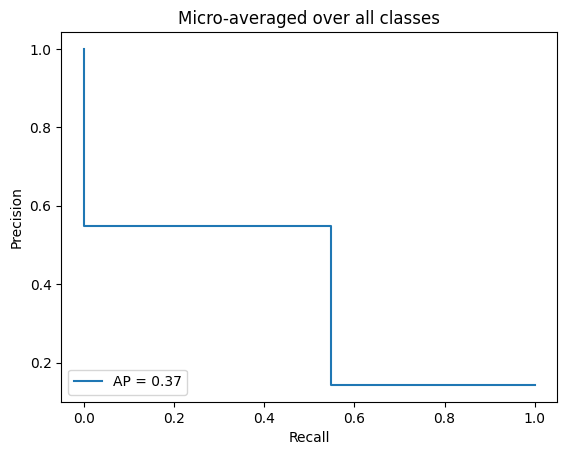

In [ ]:
n_classY = len(labelencoder.classes_)
Y_test = lb.transform(y)
Y_score = lb.transform(y_preds)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classY):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_score[:, i])
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), Y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, Y_score, average="micro")

from collections import Counter
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

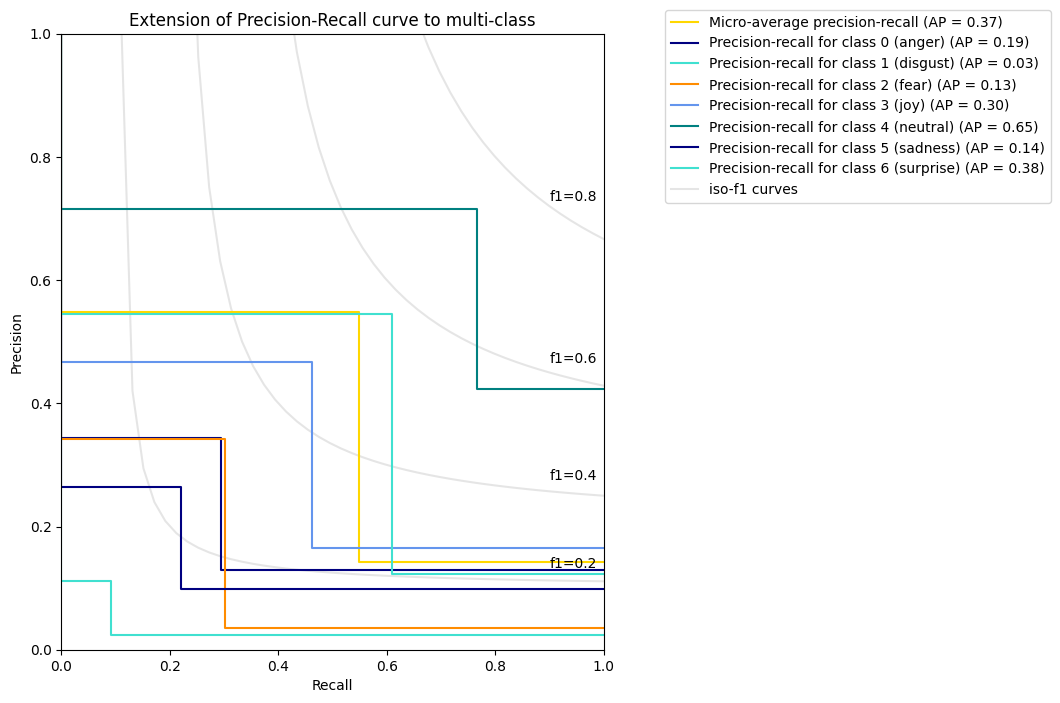

In [ ]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y_ = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y_ >= 0], y_[y_ >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y_[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classY), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i} ({labelencoder.inverse_transform([i])[0]})", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1, 1.05))
ax.set_title("Extension of Precision-Recall curve to multi-class")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()